# Seismic modeling with JUDI.jl and AzureClusterlessHPC.jl

This examples demonstrates how to use [JUDI](https://github.com/slimgroup/JUDI.jl) to model seismic data on Azure using batch processing. The macros to execute remote function calls via Azure Batch are provided by `AzureClusterlessHPC`.

First, we set environment variables to point to our credential and parameter files. These contain the Azure credentials for Azure Batch and Blob Storage, as well as parameters that specify the pool (i.e. pool name, VM type, VM image and number of nodes).

In [1]:
# Set paths to credentials + parameters
ENV["CREDENTIALS"] = joinpath(pwd(), "credentials.json")
ENV["PARAMETERS"] = joinpath(pwd(), "parameters.json")

# Load package
using AzureClusterlessHPC;

Next, we start the pool and pass it a startup file specifying the required Julia packages. In this example, we install JUDI on every node joining the pool.

In [2]:
startup_script = "pool_startup_script_judi.sh"
create_pool_and_resource_file(startup_script);

Pool 1 of 1 in canadacentral already exists.


We load the packages required for this example, which includes Julia's `Distributed` package, as well as `JUDI`. To load the packages not only on our local machine but also on the pool workers, we use the `@batchdef` macro:

In [3]:
@batchdef using Distributed, JUDI, JUDI.TimeModeling;

Next, we set up a simple two-layer velocity model for our modeling example:

In [4]:
# Set up model structure
n = (120, 100)   # (x,y,z) or (x,z)
d = (10., 10.)
o = (0., 0.)

# Velocity [km/s]
v = ones(Float32,n) .+ 0.5f0
v[:,Int(round(end/2)):end] .= 3.5f0

# Slowness squared [s^2/km^2]
m = (1f0 ./ v).^2;

From our model parameters and the squared slowness, we create a JUDI model object, as well as some options for modeling:

In [5]:
# Setup info and model structure
model = Model(n, d, o, m);

In [6]:
opt = JUDI.Options(optimal_checkpointing=false, isic=false, subsampling_factor=2, dt_comp=1.0);

In the following cell, we define our JUDI modeling function. The function takes the current shot number `isrc`, as well as the frequency `f0`, the total number of shots `nsrc` and the `model` object as input arguments. The function models the seismic data for the respective shot number and returns a `JUDI` data object with the modeled data.

In [7]:
@batchdef function model_shot(isrc, f0, nsrc, model; options=nothing)

    # Receiver geometry
    time = 1000f0
    dt = 2f0
    nxrec = 120
    xrec = range(50f0, stop=1150f0, length=nxrec)
    yrec = 0f0
    zrec = range(50f0, stop=50f0, length=nxrec)
    recGeometry = Geometry(xrec, yrec, zrec; dt=dt, t=time, nsrc=nsrc)

    # Source
    xsrc = convertToCell(range(50f0, stop=1150f0, length=nsrc))
    ysrc = convertToCell(range(0f0, stop=0f0, length=nsrc))
    zsrc = convertToCell(range(200f0, stop=200f0, length=nsrc))
    srcGeometry = Geometry(xsrc[isrc], ysrc[isrc], zsrc[isrc]; dt=dt, t=time)
    wavelet = ricker_wavelet(time, dt, f0)
    q = judiVector(srcGeometry, wavelet)

    # Operator
    ntComp = get_computational_nt(srcGeometry, recGeometry, model)
    info = Info(prod(model.n), 1, ntComp)
    F = judiModeling(info, model, srcGeometry, recGeometry; options=options)

    # Model data
    print("Modeling shot $(isrc) on $(gethostname()) with id $(myid())...\n")
    d_obs = F*q

    return d_obs
end;

Before calling the modeling function, we specify the frequency as 20 Hz and set the number of total shots to 6.

In [8]:
f0 = 0.02
nsrc = 6;

We can test the modeling function on our local machine by executing the function without any macros:

In [9]:
d_local = model_shot(5, f0, nsrc, model; options=opt);

Modeling shot 5 on pwitteBatchConsole with id 1...


Operator `forward` run in 0.07 s


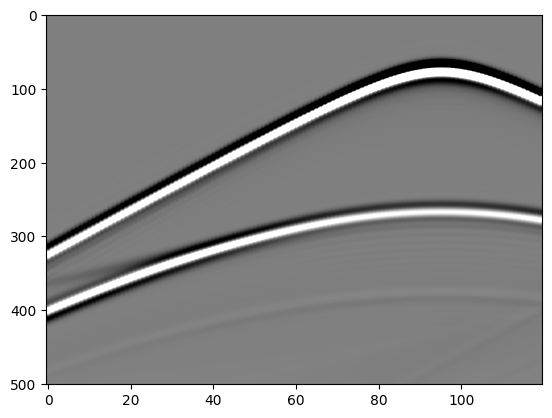

In [10]:
using PyPlot
imshow(d_local.data[1], vmin=-1, vmax=1, cmap="gray", aspect="auto");

Now that we have tested the modeling function locally, we can model a single shot record using Azure Batch by calling the function with the `@batchexec` macro. The function call returns a batch controller with Julia Futures to the result that will be stored in blob storage.

In [11]:
bctrl = @batchexec model_shot(5, f0, nsrc, model; options=opt);

The result can be loaded into memory using the `fetch` function. Afterwards, we delete the job:

In [12]:
d_batch = fetch(bctrl); delete_job(bctrl);

Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Creating job [JudiModeling_sz1KpEnH_1]...
Uploading file /home/azureuser/.julia/dev/Redwood/src/runtime/application-cmd to container [redwoodtemp]...
Uploading file /home/azureuser/.julia/dev/Redwood/src/runtime/batch_runtime.jl to container [redwoodtemp]...
Uploading file packages.dat to container [redwoodtemp]...
Uploading file task_1.dat to container [redwoodtemp]...
...............................
Fetch output from task task_1


We plot the data to ensure that it looks like the data that we modeled on our local machine:

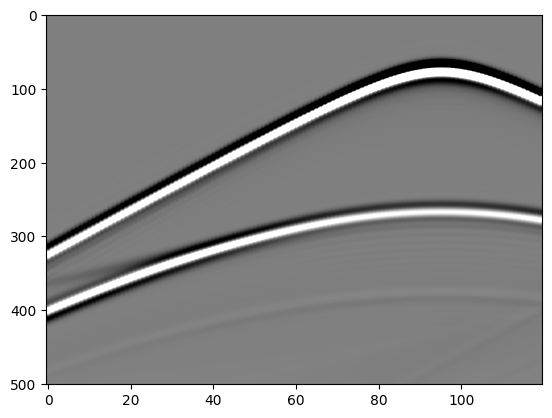

In [13]:
imshow(d_batch.data[1], vmin=-1, vmax=1, cmap="gray", aspect="auto");

Finally, we can model all shot records in parallel by calling our modeling function with `@batchexec` and `pmap`. Once again, the function call returns the batch controller with Futures to the results.

In [14]:
bctrl = @batchexec pmap(i -> model_shot(i, f0, nsrc, model; options=opt), 1:nsrc);

  0.389072 seconds (101.86 k allocations: 5.644 MiB)


We load the data into memory and plot the results:

In [15]:
d_pmap = fetch(bctrl); delete_job(bctrl);

Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Creating job [JudiModeling_fMPtJ1rw_1]...
Uploading file /home/azureuser/.julia/dev/Redwood/src/runtime/application-cmd to container [redwoodtemp]...
Uploading file /home/azureuser/.julia/dev/Redwood/src/runtime/batch_runtime.jl to container [redwoodtemp]...
Uploading file packages.dat to container [redwoodtemp]...
Uploading file task_1.dat to container [redwoodtemp]...
Uploading file task_2.dat to container [redwoodtemp]...
Uploading file task_3.dat to container [redwoodtemp]...
Uploading file task_4.dat to container [redwoodtemp]...
Uploading file task_5.dat to container [redwoodtemp]...
Uploading file task_6.dat to container [redwoodtemp]...
...........................
Fetch output from task task_6........
Fetch output from task task_3....................
Fetch output from task task_4.................
Fetch output from task task_5................
Fetch output from task task_1.......................
Fetch output from ta

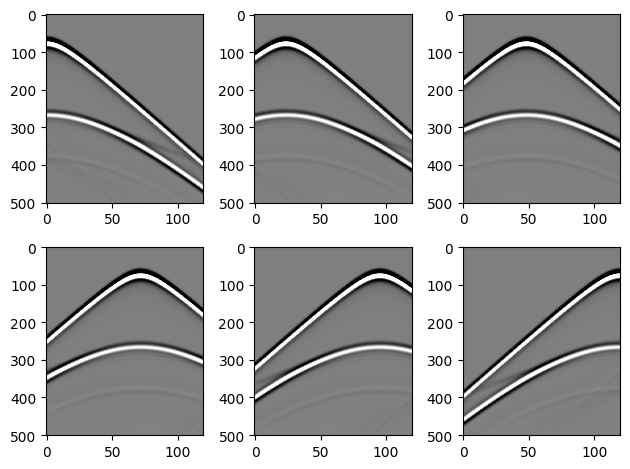

In [16]:
for i=1:nsrc
    subplot(2, Int(round(nsrc/2)), i)
    imshow(d_pmap[i].data[1], vmin=-1, vmax=1, cmap="gray", aspect="auto")
end
tight_layout();

We now clean up our resources, which includes deleting the job, the blob container in which the results and temporary files were stored as well as the pool:

In [17]:
destroy!(bctrl);

## Copyright

Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License (MIT). See LICENSE in the repo root for license information.